# The San Francisco Crime Dataset and You
## Staying safe in a city that's seen some stuff
Whether it be the rising costs of rent, gentrification because of high tech companies, or any one of a number of different social issues in the city, San Francisco has been the center of many debates. Let's join the bandwagon and look into crime throughout the city!

To begin diving into this dataset, we started by importing some of the most used packages, such as Pandas to manipulate data, sklearn to build models, and numpy to do math.

In [4]:
import pandas as pd
import numpy as np
# for building a model with BernoulliNB
from sklearn.naive_bayes import BernoulliNB
# for building a model with RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold
# for validating the models
from sklearn import cross_validation
from sklearn import preprocessing
# used to create a submission file for Kaggle
import gzip, csv
import matplotlib.pyplot as plt
%matplotlib inline

Yup, lots of imports. However, there are some noticeable additions there. The sklearn libraries are great for building and validating models, which is what we are going to dive into after some initial visualizations. More specifically, we are going to focus on building models with BernoulliNB and RandomForestClassifier. But first, let's import our data and have a peek at what may be interesting.

In [5]:
train = pd.read_csv('train.csv')
print train.head()
print train.describe()

                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.4387

First thing that is important to notice is out `data.describe()` call only shows two columns, X and Y. This means that we are going to need to play a lot with our data if we want to make it understandable to a computer, and if we want to build a model from it. However, since the X and Y values are readily available to us, let us build a map to show where crimes happen in SF, which brings us to section 1:
## Visualizations
To start, let's build a map of crime in SF. (inspiration drawn from https://www.kaggle.com/victoregb/sf-crime/sf-pd-districts-and-top-10-crime-maps/code)

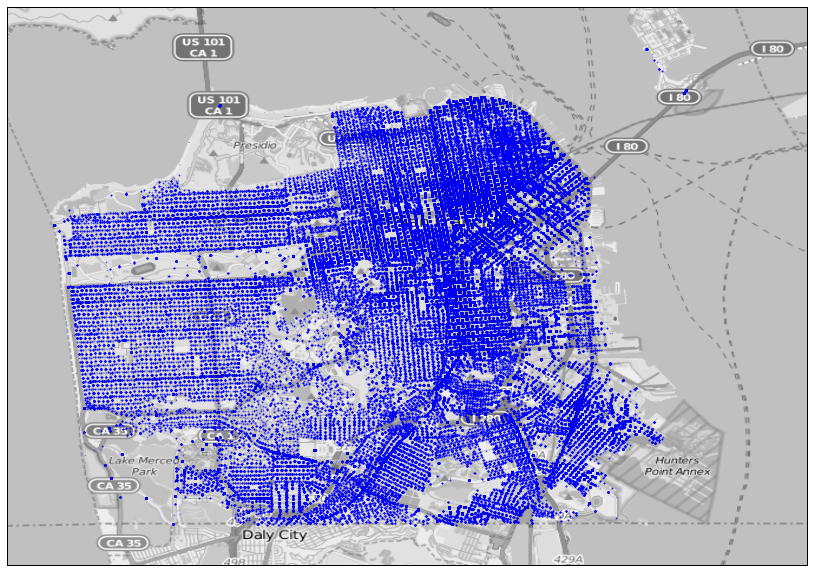

In [6]:
from mpl_toolkits.basemap import Basemap
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

fig1 = plt.figure(figsize = (20,10))

map = Basemap(projection='cyl',
                  resolution = 'h',
                  llcrnrlon = -122.52469,
                  llcrnrlat = 37.69862,
                  urcrnrlon = -122.33663,
                  urcrnrlat = 37.82986,
                  lat_0=37.752303,
                  lon_0=-122.445576)

plt.imshow(mapdata, cmap = plt.get_cmap('gray'),
            extent=[-122.52469, -122.33663, 37.69862, 37.82986])

x, y = train.X, train.Y
map.scatter(x, y, 3, marker='.', color='b', alpha=0.25)

plt.show()
plt.savefig('map.png')

Yikes. That's a lot of crime. Also, this shows us a bit about location and density, but refinement on our end could show us highest amounts of certain crime in specific areas, and other useful metrics. In this exploration however, we are more concerned with building a model, and while this map is pretty, it does not help much of our understanding.
Looking at some other interesting metrics, it is worth noting the amount of crimes on each day of the week:

In [7]:
print train.DayOfWeek.value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64


Friday may not be the best day to take the dog for a walk late at night. Looking at this more visually shows a similar idea:

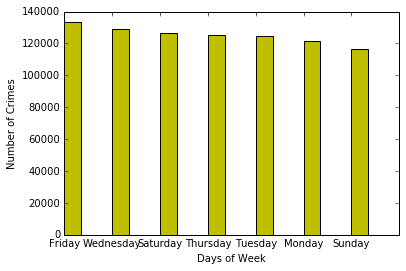

In [8]:
fig, ax = plt.subplots()
weekRects = ax.bar(np.arange(7), train.DayOfWeek.value_counts(), 0.35, color ='y')
ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Days of Week')
ax.set_xticks(np.arange(7), 0.55)
ax.set_xticklabels(('Friday','Wednesday','Saturday','Thursday','Tuesday','Monday', 'Sunday'))

Cool, but not much difference between days of the week. Let's instead look at each hour and day of the week, with the hypothesis being that most crimes happen during the night. First we clean up the data:

In [9]:
def parse_date(Dates):
    """ Convert a date in YYYY-MM-DD HH:MM:SS to a tuple
        containing year, month, day, and hours each expressed
        as an integer. Used from Paul Ruvolo's example in bikeshare kaggle dataset

        >>> parse_date("2014-04-05 14:00:00")
        (2014, 4, 5, 14)
    """
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

train['Hour'] = train.Dates.apply(lambda x: parse_date(x)[3])

# map days of week to integers
dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}
train['DOW'] = train.DayOfWeek.map(dow)

#take a count of Categories and put it in a numpy array so I can use it
cats = pd.Series(train.Category.values.ravel()).unique()#make categories into a unique array
cats.sort() #sort alphabetically so it can be used across days

And now with new columns of clean data, let's plot them:

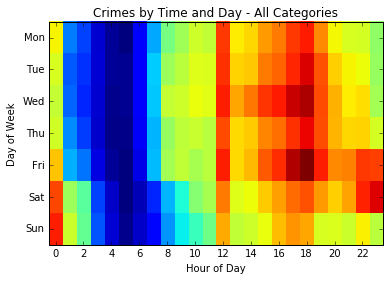

In [10]:
plt.figure(1,figsize=(6,4))
plt.hist2d(
    train.Hour.values,
    train.DOW.values,
    bins=[24,7],
    range=[[-0.5,23.5],[-0.5,6.5]]
)
plt.xticks(np.arange(0,24,2))
plt.xlabel('Hour of Day')
plt.yticks(np.arange(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Day of Week')
plt.gca().invert_yaxis()
plt.title('Crimes by Time and Day - All Categories')

Very nice! This gives us some ideas, mainly that it seems most crimes happen around 6pm on a Friday. One big thing that we are missing, however, is what crimes occur when. It's easy to say most crimes happen then, but what about white collar thefts, or carjacking? To look more into this, let's create subplots for each individual crime:

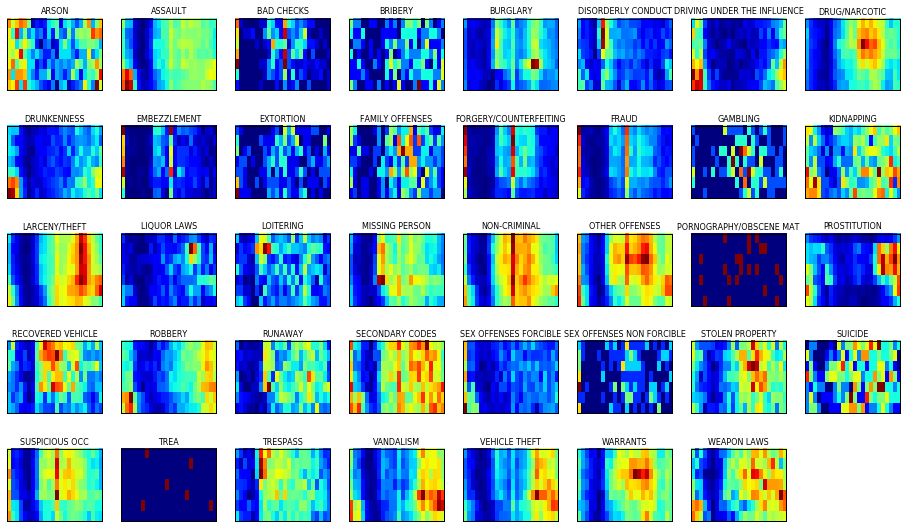

In [11]:
plt.figure(2,figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
for i in np.arange(1,cats.size + 1):
    ax = plt.subplot(5,8,i)
    ax.set_title(cats[i - 1],fontsize=8)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.hist2d(
        train[train.Category==cats[i - 1]].Hour.values,
        train[train.Category==cats[i - 1]].DOW.values, 
        bins=[24,7],
        range=[[-0.5,23.5],[-0.5,6.5]]
    )
    plt.gca().invert_yaxis()

This is a nice overview of all crimes. One interesting point is that most white collar crimes (embezzlement, forgery, fraud) happen around 12 noon. Weird, but that may just be that they were input into the system at noon because no specific time could be attributed to the crime.

So at this point, we have an idea of when most crimes happen, a visualization on a map of this data, and we have started to clean the data. Let's quickly show visualizations for which district has the highest levels of crime:

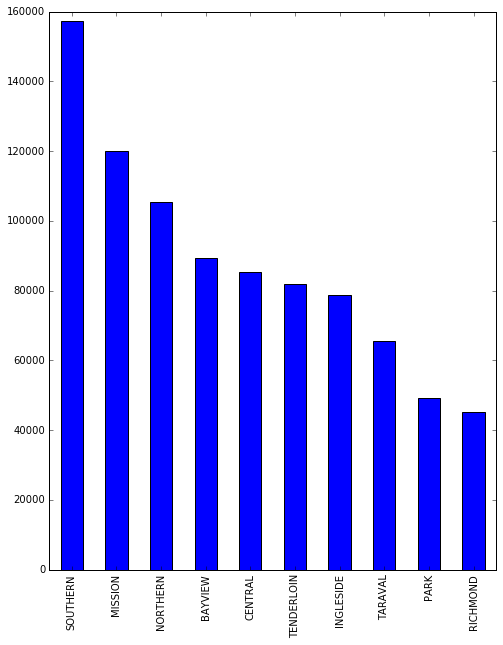

In [12]:
train.PdDistrict.value_counts().plot(kind='bar', figsize=(8,10))

...the number of cases per hour in each different district:

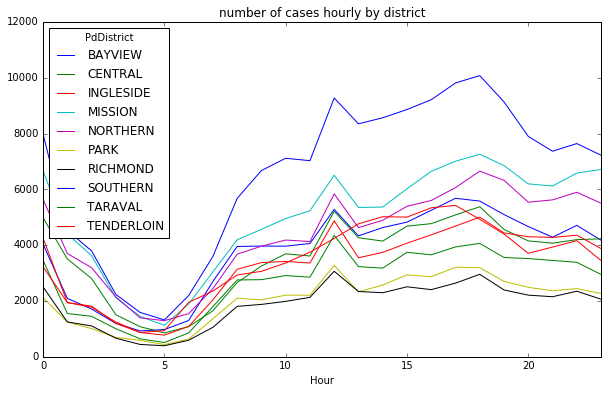

In [13]:
train['event']=1
hourly_district_events = train[['PdDistrict','Hour','event']].groupby(['PdDistrict','Hour']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hour', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))
plt.savefig('hourly_events_by_district.png')

...and the amount of crimes over hours:

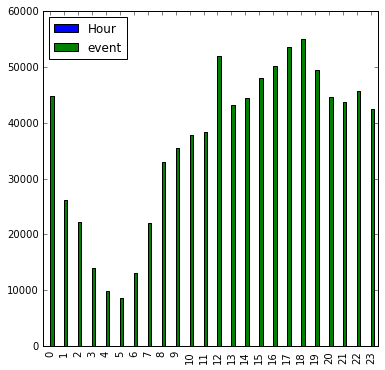

In [14]:
hourly_events = train[['Hour','event']].groupby(['Hour']).count().reset_index()
hourly_events.plot(kind='bar', figsize=(6, 6))
plt.savefig('hourly_events.png')

(The last graph adds little, but it is a great sanity check to show that most crimes happen more at night than the morning)
With all these visualizations, we now have a bit of an idea of when crimes happen, where they happen, and possible hypotheses to explain why they happen (location location location). With this in mind, we now continue on to build a model, factoring in location and time.

## Initial Model Building
As mentioned before, we are going to start building a model, with interest placed on location and day of week. Let's start by pruning our data (we are also going to load `train.csv` again, but clean it more thorougly. This is why we changed the variable name to `data`.

With the method `cleanup()` we can make days of week useful for the model, along with police districts, dates, and X and Y locations.

In [15]:
def parse_date(Dates):
    """ Convert a date in YYYY-MM-DD HH:MM:SS to a tuple
        containing year, month, day, and hours each expressed
        as an integer. Used from Paul Ruvolo's example in bikeshare kaggle dataset
    """
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

def cleanup(data):
    dow = {
        "Monday" : 0,
        "Tuesday" : 1,
        "Wednesday" : 2,
        "Thursday" : 3,
        "Friday" : 4,
        "Saturday" : 5,
        "Sunday" : 6
    }
    data["DOW"] = data.DayOfWeek.map(dow)
    pds = {
        "SOUTHERN" : 0,
        "MISSION" : 1,
        "NORTHERN" : 2,
        "BAYVIEW" : 3,
        "CENTRAL" : 4,
        "TERNDERLOIN" : 5,
        "INGLESIDE" : 6,
        "TARAVAL" : 7,
        "PARK" : 8,
        "RICHMOND" : 9
    }
    data["pds"] = data.PdDistrict.map(pds)
    # for crimes without PD, use "Other" : 10
    data["pds"] = data["pds"].fillna(10)
    data.X.replace(-120.5, data["X"].median(), inplace = True)
    data.Y.replace(90, data["Y"].median(), inplace = True)
    data["Year"] = data.Dates.apply(lambda x: parse_date(x)[0])
    data["Month"] = data.Dates.apply(lambda x: parse_date(x)[1])
    data["Hour"] = data.Dates.apply(lambda x: parse_date(x)[3])
    return data

The data cleaning train has no brakes! Let's apply this method to our data.

In [16]:
data = pd.read_csv('train.csv')
data = cleanup(data)

And so now we are going to do the predictive model. We drew inspiration from this script (https://www.kaggle.com/sonuk7/sf-crime/prediction-with-bernoulinb/code). Bernoulli distributions deal with discrete variables where we have a two-point distribution. The BernoulliNB method gives us the probability of an incident fitting a Category when the probability is trained with our input columns to be better than 50-50. We're using this because this data set deals a lot with categorical variables instead of a bunch of integers that could be continous.

In [17]:
cats = data.Category.values
cleanData = data.drop(["Address","Category","Dates","Descript","X", "Y","Resolution", "DayOfWeek", "PdDistrict"], axis=1)

model = BernoulliNB()
model.fit(cleanData.dropna(), cats)

scores = cross_validation.cross_val_score(model, cleanData, data["Category"], cv = 3)
print scores

[ 0.19976153  0.19864289  0.19928998]


We would then generate the test model and output that, but since we have 3 different iterations and the test model generator stays about the same, I can just tell you the score received with BernoulliNB was 2.66746. (More specifics can be found in the previous iteration notebooks)

Concerning the score, 2.66746 is pretty good. It shows that BernoulliNB is a pretty good tool to use for fitting data, however we may want to overfit our data with more work, and see if we get a better score.

## Initial Refinement: Dummy Variables

Next, we are going to attempt to use dummy variables to define new columns for more of our data. Using dummies instead of reassignment could increase precision by separating the categorical variables. After all, days of the week aren't really on a continuous scale; it wasn't completely fair to map them as such. They're discrete instances where it either is or isn't a given day.

In [18]:
def cleanupDummies(data):
    data.X.replace(-120.5, data["X"].median(), inplace = True)
    data.Y.replace(90, data["Y"].median(), inplace = True)
    data["Year"] = data.Dates.apply(lambda x: parse_date(x)[0])
    data["Month"] = data.Dates.apply(lambda x: parse_date(x)[1])
    data["Hour"] = data.Dates.apply(lambda x: parse_date(x)[3])
    data = pd.concat((data, pd.get_dummies(data.DayOfWeek, prefix = "dow")), axis = 1)
    data = pd.concat((data, pd.get_dummies(data.PdDistrict, prefix = "pds")), axis = 1)
    return data

data_dummies = pd.read_csv('train.csv')
data_dummies = cleanupDummies(data_dummies)

data_dummies.columns

Index([u'Dates', u'Category', u'Descript', u'DayOfWeek', u'PdDistrict',
       u'Resolution', u'Address', u'X', u'Y', u'Year', u'Month', u'Hour',
       u'dow_Friday', u'dow_Monday', u'dow_Saturday', u'dow_Sunday',
       u'dow_Thursday', u'dow_Tuesday', u'dow_Wednesday', u'pds_BAYVIEW',
       u'pds_CENTRAL', u'pds_INGLESIDE', u'pds_MISSION', u'pds_NORTHERN',
       u'pds_PARK', u'pds_RICHMOND', u'pds_SOUTHERN', u'pds_TARAVAL',
       u'pds_TENDERLOIN'],
      dtype='object')

Now with these dummy columns, let's create a new model with BernoulliNB.

In [19]:
model = BernoulliNB()
cats = data.Category.values
dataDrops = data.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)
dummyDataDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)

model.fit(dataDrops.dropna(), cats)
without_dummies_scores = cross_validation.cross_val_score(model, dataDrops, data["Category"], cv = 3)

model.fit(dummyDataDrops.dropna(), cats)
with_dummies_scores= cross_validation.cross_val_score(model, dummyDataDrops, data["Category"], cv=3)

with_dummies_scores.mean() - without_dummies_scores.mean()

0.021247125369906333

So it looks like using dummies gives us a little improvement, which means this could be a good choice! We're going to go ahead and generate a test submission file for kaggle. This example is used throughout to generate all test files so for reference:

## Generating a Testing File

In [20]:
testDummies = pd.read_csv('test.csv')
testDummies = cleanupDummies(testDummies)

idx = testDummies.Id.values
cats = data.Category.values

droppedTestDummies = testDummies.drop(["Id","Address","Dates", "DayOfWeek", "PdDistrict"], axis=1)

model = BernoulliNB()
model.fit(dummyDataDrops.dropna(), cats)
predicted = model.predict_proba(droppedTestDummies)
labels =['Id']
for i in model.classes_:
    labels.append(i)
with gzip.open('bernoulinb.csv.gz', 'wb') as outf:
    fo =csv.writer(outf, lineterminator = '\n' )
    fo.writerow(labels)
    
    for i, pred in enumerate(predicted):
        fo.writerow([i] + list(pred))

This model gets us a score of 2.61102, which is a minor improvement. Let's continue refining with more cleaning, this time looking at the X and Y data itself. (some inspiration pulled from https://www.kaggle.com/c/sf-crime/forums/t/18853/feature-engineering-of-lat-long-x-y-helps)

In [21]:
# no new coord system
def cleanupDummiesOld(data):
    data.X.replace(-120.5, data["X"].median(), inplace = True)
    data.Y.replace(90, data["Y"].median(), inplace = True)
    data["Year"] = data.Dates.apply(lambda x: parse_date(x)[0])
    data["Month"] = data.Dates.apply(lambda x: parse_date(x)[1])
    data["Hour"] = data.Dates.apply(lambda x: parse_date(x)[3])
    data =pd.concat((data, pd.get_dummies(data.DayOfWeek, prefix="dow")), axis=1)
    data = pd.concat((data, pd.get_dummies(data.PdDistrict, prefix="pds")), axis=1)
    return data
oldData = pd.read_csv('train.csv')
oldData = cleanupDummiesOld(oldData)

# new coord system
def cleanupDummies(data):
    data.X.replace(-120.5, data["X"].median(), inplace = True)
    data.Y.replace(90, data["Y"].median(), inplace = True)
    xy_scaler=preprocessing.StandardScaler()
    xy_scaler.fit(data[["X","Y"]])
    data[["X","Y"]]=xy_scaler.transform(data[["X","Y"]])
    data["rot45_X"]=0.707*data["Y"]+0.707*data["X"]
    data["rot45_Y"]=0.707*data["Y"]-0.707*data["X"]
    data["rot30_X"]=(1.732/2)*data["X"]+(1./2)*data["Y"]
    data["rot30_Y"]=(1.732/2)*data["Y"]-(1./2)*data["X"]
    data["rot60_X"]=(1./2)*data["X"]+(1.732/2)*data["Y"]
    data["rot60_Y"]=(1./2)*data["Y"]-(1.732/2)*data["X"]
    data["radial_r"]=np.sqrt(np.power(data["Y"],2)+np.power(data["X"],2))
    
    data["Year"] = data.Dates.apply(lambda x: parse_date(x)[0])
    data["Month"] = data.Dates.apply(lambda x: parse_date(x)[1])
    data["Hour"] = data.Dates.apply(lambda x: parse_date(x)[3])
    data =pd.concat((data, pd.get_dummies(data.DayOfWeek, prefix="dow")), axis=1)
    data = pd.concat((data, pd.get_dummies(data.PdDistrict, prefix="pds")), axis=1)
    return data

data_dummies=pd.read_csv('train.csv')
data_dummies= cleanupDummies(data_dummies)

data_dummies.columns

Index([u'Dates', u'Category', u'Descript', u'DayOfWeek', u'PdDistrict',
       u'Resolution', u'Address', u'X', u'Y', u'rot45_X', u'rot45_Y',
       u'rot30_X', u'rot30_Y', u'rot60_X', u'rot60_Y', u'radial_r', u'Year',
       u'Month', u'Hour', u'dow_Friday', u'dow_Monday', u'dow_Saturday',
       u'dow_Sunday', u'dow_Thursday', u'dow_Tuesday', u'dow_Wednesday',
       u'pds_BAYVIEW', u'pds_CENTRAL', u'pds_INGLESIDE', u'pds_MISSION',
       u'pds_NORTHERN', u'pds_PARK', u'pds_RICHMOND', u'pds_SOUTHERN',
       u'pds_TARAVAL', u'pds_TENDERLOIN'],
      dtype='object')

Yep, that's a lot of code, however what it does is fairly straightforward. Basically, it uses feature engineering to make the coordinate use more intuitive. sklearn.preprocessing.StandardScaler scales the XY coords so that its variance and magnitude can't dwarf the other variables' features. With scaling, the XY coords are less likely to dominate the objective function. 

We also created new cartesian coordinate systems that are rotated around SF and a polar coordinate system. All of these center on the SF area and convey more relevant spatial information.

Next, we ran the model with 5 configurations:
original model
model with all additions (coordinate adjustment and dummy variables)
model with only new coordinates
model with only scaled xy
model with only the polar coordinates

The code to run these tests is below, and the scores follow that.

In [22]:
model = BernoulliNB()
cats = data_dummies.Category.values
origDrops = oldData.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)

dummyDataDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)

xyCordsDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict", "X","Y"], axis=1)

newCordsDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict", "rot45_X","rot45_Y","rot30_X","rot30_Y","rot60_X","rot60_Y","radial_r"], axis=1)

polarCordsOnly = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict", "rot45_X","rot45_Y","rot30_X","rot30_Y","rot60_X","rot60_Y","X", "Y"], axis=1)

model.fit(origDrops.dropna(),cats)
orig_score = cross_validation.cross_val_score(model, origDrops, data_dummies["Category"], cv=3)

model.fit(dummyDataDrops.dropna(), cats)
with_dummies_scores= cross_validation.cross_val_score(model, dummyDataDrops, data_dummies["Category"], cv=3)

model.fit(xyCordsDrops.dropna(), cats)
without_xy_scores= cross_validation.cross_val_score(model, xyCordsDrops, data_dummies["Category"], cv=3)

model.fit(newCordsDrops.dropna(), cats)
without_newcords_scores= cross_validation.cross_val_score(model, newCordsDrops, data_dummies["Category"], cv=3)

model.fit(polarCordsOnly.dropna(), cats)
polarcords_scores= cross_validation.cross_val_score(model, polarCordsOnly, data_dummies["Category"], cv=3)

print "original score:", orig_score.mean()
print "score with all additions:",with_dummies_scores.mean()
print "with only new coordinate systems:",without_xy_scores.mean()
print "scaled xy only score:",without_newcords_scores.mean()
print "with only the polar coordinates:", polarcords_scores.mean()

original score: 0.220478593273
score with all additions: 0.195751107956
with only new coordinate systems: 0.197247620754
scaled xy only score: 0.210547522574
with only the polar coordinates: 0.220478593273


From here, test cases were generated for each model variant, similar to the test generator above. The scores from Kaggle were as follows (lower is better):

original score: 2.611

score with all additions: 2.9

with only new coordinate systems: 2.7

scaled xy only score: 2.638

with only the polar coordinates: 2.611

So it seems our original score was pretty good, and we were only able to match that using only polar coordinates. Matching the two scores shouldn't come as too much of a surprise as we just transposed the X Y columns into polar, thus not overfitting but more so converting. However, it is more surprising that the model score did not improve much. This can probably be attributed to too much overfitting of our data, where having dummy values along with different coordinates did not really change much to help the model. However, we can try one more thing, by adjusting what we create our model with to see if we improve our score. To do this, we are going to implement RandomForestClassifier:

In [23]:
# we imported these earlier, but the libraries used here are as follows:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.cross_validation import KFold

dummyDataDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)

alg = RandomForestClassifier(random_state = 1, n_estimators = 10, max_depth = 18)

scores = cross_validation.cross_val_score(alg, dummyDataDrops, data_dummies["Category"], cv=6)
print scores

[ 0.21487575  0.20834985  0.20009293  0.21128195  0.16919176  0.09571713]


And now let's create a submission file (there are some changes because of using alg instead of model):

In [24]:
testDummies = pd.read_csv('test.csv')
testDummies = cleanupDummies(testDummies)

idx = testDummies.Id.values
cats = data_dummies.Category.values

dummyDataDrops = data_dummies.drop(["Address","Category","Dates","Descript","Resolution", "DayOfWeek", "PdDistrict"], axis=1)
test_dummyDataDrops = testDummies.drop(["Address","Dates", "DayOfWeek", "PdDistrict", "Id"], axis=1)

alg = RandomForestClassifier()
alg.fit(dummyDataDrops.dropna(), cats)
predicted = alg.predict_proba(test_dummyDataDrops)

labels =['Id']
for i in alg.classes_:
    labels.append(i)
with gzip.open('randomforrest.csv.gz', 'wb') as outf:
    fo =csv.writer(outf, lineterminator = '\n' )
    fo.writerow(labels)
    
    for i, pred in enumerate(predicted):
        fo.writerow([i] + list(pred))

With the RandomForest implementation we used, we did not do too well, getting a score of 2.63450. As to why, we may be overfitting our data too much. This implementation takes into account all rotations of the coordinates and also the polar values we used. Looking forward, dropping certain aspects may increase the score, however how much is left to be decided. Our previous score still had the highest score on Kaggle, so we stayed with that submission.

## Conclusion
For one, this project was an interesting challenge. The data we were given had only X and Y coordinates as number values, and everything else was categorical to some variety. This meant that much of the time we spent on development revolved around fixing the data and cleaning it to better be used in a model. Creating some visualizatinos helped us decide on what data might be the most interesting to build a model from, but eventually when it came to building a model we had only a few choices. BernoulliNB was the best result by a fair amount, and many of our other explorations (using dummy variables and transposing coordinate systems) only caused a worse score. Along with that, the implementation of the model using RandomForestClassifier had no positive effects on the score either. It seems that including all the extra columns we created only resulted in overly overfit data, too much to create a more accurate model. If we had more time to move forward, we might have pruned what columns had the worst result on the score, and created a new RandomForestClassifier with different columns to see if a higher score could be reached.